<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing interpretation methods with final model

First we clone our Github so that we can load in Tomi's final model, then we will implement all of our different interpretation methods for this model, and compare them. For the sake of simplicity, a limited number of plots have been added.

In [ ]:

!git clone https://github.com/y-oth/dst_assessment2
%cd dst_assessment2




Cloning into 'dst_assessment2'...
remote: Enumerating objects: 3285, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 3285 (delta 26), reused 10 (delta 5), pack-reused 3228 (from 3)
Receiving objects: 100% (3285/3285), 226.85 MiB | 15.83 MiB/s, done.
Resolving deltas: 100% (96/96), done.
Updating files: 100% (6576/6576), done.
/content/dst_assessment2


In [ ]:
import os, glob
glob.glob("**/*.pth", recursive=True)


['Tomi/final_model.pth', 'report/final_model.pth']

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# Setting to GPU if available
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(f"Using: {device}")

Using: cuda


# Final model

Here we create an instance of the final model that Tomi trained, and import the learned weights that have been saved, along with the optimal parameters.

In [ ]:
class FlexibleCNN(nn.Module):
    def __init__(self, n_layers, n_filters, kernel_sizes, dropout, fc_size):
        super().__init__()

        blocks = []

        in_channels = 3

        for i in range(n_layers):
            out_channels = n_filters[i]
            kernel_size = kernel_sizes[i]

            padding = (kernel_size - 1) // 2

            # Individual CNN block
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )

            blocks.append(block)

            in_channels = out_channels

        # Combine all blocks
        self.features = nn.Sequential(*blocks)

        self.dropout = dropout
        self.fc_size = fc_size

        self.classifier = None

    def _create_classifier(self, flattened_size, device):
        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(flattened_size, self.fc_size),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.fc_size, 4)
        ).to(device)

    def forward(self, x):
        device = x.device

        x = self.features(x)

        flattened = torch.flatten(x, 1)
        flattened_size = flattened.size(1)

        if self.classifier is None:
            self._create_classifier(flattened_size, device)

        return self.classifier(flattened)

In [ ]:
best_params = {
    "n_layers": 4,
    "n_filters_0": 256,
    "n_filters_1": 80,
    "n_filters_2": 48,
    "n_filters_3": 240,
    "kernel_size_0": 3,
    "kernel_size_1": 5,
    "kernel_size_2": 3,
    "kernel_size_3": 5,
    "dropout": 0.1265531928742637,
    "fc_size": 400,
    "lr": 0.0008484833582874335
}

n_layers = best_params["n_layers"]
n_filters = [best_params[f"n_filters_{i}"] for i in range(n_layers)]
kernel_sizes = [best_params[f"kernel_size_{i}"] for i in range(n_layers)]
dropout = best_params["dropout"]
fc_size = best_params["fc_size"]

learning_rate = best_params["lr"] # probably don't need this one

# Instantiating the CNN with specified hyper parameters
model = FlexibleCNN(n_layers, n_filters, kernel_sizes, dropout, fc_size).to(device)

# Dummy input to create the classifier layer
dummy_input = torch.randn(1, 3, 224, 224).to(device)
model(dummy_input)

# Loading the model with saved weights
model.load_state_dict(torch.load("report/final_model.pth"))
model.eval()

FlexibleCNN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(256, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(80, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(48, 240, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Dropout(p=0.1265531928742637, inplace=False)
    (1): Linear(in_features=47040, out_fe

## Dataloaders

Here we load in our data in exactly the same way that was done when training the model.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = datasets.ImageFolder("data/Training", transform=transform)
test_dataset = datasets.ImageFolder("data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Transfer Learning

Create Dataloaders


In [ ]:
import numpy as np
from tqdm import tqdm

def dataloader_to_numpy(dataloader):
    X_list, y_list = [], []
    for images, labels in tqdm(dataloader):
        X_list.append(images.numpy())
        y_list.append(labels.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X.transpose(0, 2, 3, 1), y   # convert to (N, H, W, C) for Keras


In [ ]:
X_train, y_train = dataloader_to_numpy(train_loader)
X_test,  y_test  = dataloader_to_numpy(test_loader)

Define our EfficientNet model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet import preprocess_input

num_classes = len(train_dataset.classes)

effnet_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Lambda(preprocess_input),
    EfficientNetB0(include_top=False, weights="imagenet", pooling="avg"),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])



effnet_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


Train Model

In [ ]:
effnet_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.1,
    verbose=1
)


Evaluate Model

In [ ]:
effnet_model.evaluate(
    x=X_test,
    y=y_test,
    verbose=1
)


Produce Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = effnet_model.predict(X_test).argmax(axis=1)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Plot Loss Curves

In [ ]:
history = effnet_model.fit(...)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


Add Guassian Blur to data and evalute robustness

In [ ]:
noisy = X_test + 0.1*np.random.randn(*X_test.shape)
effnet_model.evaluate(noisy, y_test)

# Vanilla Gradient Method Implementation

In [ ]:
def compute_vanilla_saliency(model, image_tensor, target_class, device):
    """
    Compute vanilla gradient saliency map for a single input image.
    image_tensor: shape [1, C, H, W]
    """

    model.eval()
    image_tensor = image_tensor.clone().detach().to(device)
    image_tensor.requires_grad_(True)

    # Forward pass - computes logits f(x)
    output = model(image_tensor)
    score = output[0, target_class]

    # Backward pass - compute gradient at target class
    model.zero_grad()
    score.backward()
    grads = image_tensor.grad.detach().cpu().numpy()[0]

    # Reduce channels to 2d
    saliency = np.max(np.abs(grads), axis=0)

    # Normalise to [0,1]
    saliency -= saliency.min()
    if saliency.max() != 0:
        saliency /= saliency.max()

    return saliency

# SmoothGrad Implementation

In [ ]:
def compute_smoothgrad(model, image_tensor, target_class, device,
                       n_samples=50, stdev=0.15, magnitude=True):
    """
    SmoothGrad implementation.
    Adds Gaussian noise to input and averages gradient saliency.
    Choose sigma=0.15 for reasons shown in SmoothGrad intro
    """

    model.eval()

    # Convert input to numpy for noise sampling
    x_np = image_tensor.clone().detach().cpu().numpy()
    img_min, img_max = x_np.min(), x_np.max()
    noise_std = stdev * (img_max - img_min)

    total_gradients = np.zeros_like(x_np)

    for i in range(n_samples):

        # Add Gaussian noise
        noise = np.random.normal(0, noise_std, size=x_np.shape).astype(np.float32)
        noisy_input = x_np + noise

        noisy_tensor = torch.from_numpy(noisy_input).to(device)
        noisy_tensor.requires_grad_(True)

        # Forward
        output = model(noisy_tensor)
        score = output[0, target_class]

        # Backward
        model.zero_grad()
        score.backward()

        grads = noisy_tensor.grad.detach().cpu().numpy()

        # Accumulate gradients
        if magnitude:
            total_gradients += grads * grads
        else:
            total_gradients += np.abs(grads)

    # Average
    avg_grad = total_gradients[0] / n_samples  # remove batch dim
    saliency = np.max(avg_grad, axis=0)

    # Normalise [0,1]
    saliency -= saliency.min()
    if saliency.max() != 0:
        saliency /= saliency.max()

    return saliency

# Integrated Gradients Method Implementation

In [ ]:
def integrated_gradients(model, x, baseline=None, m_steps=50):
    """
    Compute Integrated Gradients for an input x.
    model: pytorch model
    x: input image tensor of shape (1, C, H, W)
    baseline: same shape as x
    m_steps: number of steps in the Riemann approximation
    """

    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(x)

    # interpolate between baseline and x
    alphas = torch.linspace(0, 1, m_steps).reshape(-1, 1, 1, 1).to(x.device)
    interpolated = baseline + alphas * (x - baseline)

    # store gradients
    gradients = []

    for i in range(m_steps):
        interpolated_i = interpolated[i].unsqueeze(0).requires_grad_(True)
        output = model(interpolated_i)
        target = output.max(1)[0]  # predicted class score

        model.zero_grad()
        target.backward()

        gradients.append(interpolated_i.grad.detach())

    # approximate integral
    avg_gradients = torch.mean(torch.stack(gradients), dim=0)

    # IG formula
    ig = (x - baseline) * avg_gradients
    return ig

# SG-IG Method Implementation

In [ ]:
def smooth_integrated_gradients(
    model, x, baseline=None, m_steps=50, n_samples=25, noise_sigma=0.1
):
    """
    Compute Smooth Integrated Gradients.
    Averaging IG over noise-perturbed copies of input x.
    """

    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(x)

    all_igs = []

    for _ in range(n_samples):
        noise = torch.normal(mean=0, std=noise_sigma, size=x.shape).to(x.device)
        x_noisy = x + noise
        ig = integrated_gradients(model, x_noisy, baseline, m_steps)
        all_igs.append(ig)

    return torch.mean(torch.stack(all_igs), dim=0)

# Grad-CAM Method Implementation

Grad-CAM requires a package, so first we install this.

In [ ]:
!pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Get the last block
last_block = model.features[-1]

# Extract the Conv2d layer inside that block
target_layer = last_block[0]

# Initialise GradCAM
cam = GradCAM(model=model,
              target_layers=[target_layer])



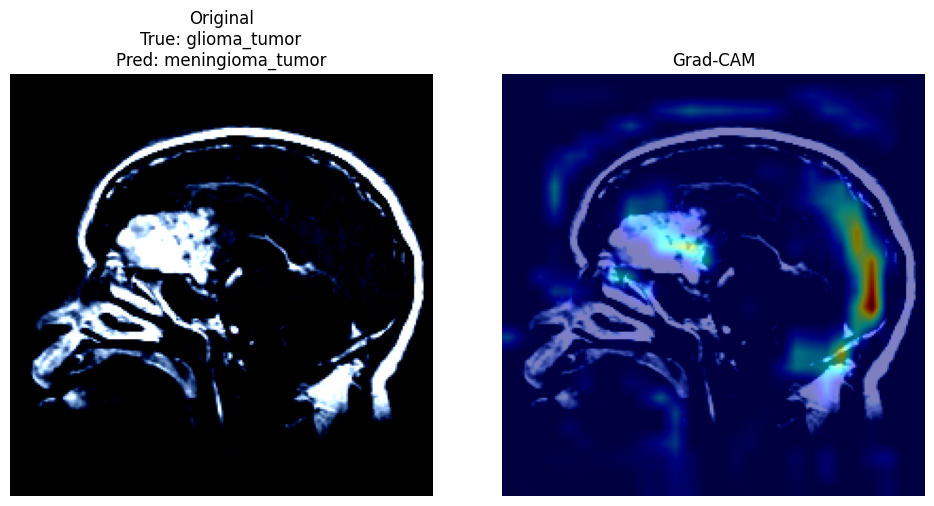

In [ ]:
import cv2
import numpy as np

# Get explainer imaage from test set

model.eval()
images, labels = next(iter(test_loader))

image = images[1].to(device)         # shape (3,224,224)
label = labels[1]


# Make prediction
with torch.no_grad():
    output = model(image.unsqueeze(0))
    _, pred = torch.max(output, 1)


# Create GradCAM heatmap
input_tensor = image.unsqueeze(0)  # shape (1,3,224,224)
target = [ClassifierOutputTarget(pred.item())]

grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0]

# Convert tensor image → numpy RGB image (0-1)
img = images[1].permute(1, 2, 0).cpu().numpy()
img = np.clip(img, 0, 1)

# Ensure CAM is numpy float32
grayscale_cam = grayscale_cam.astype(np.float32)

# Overlay
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)


# Plot GradCAM visualization

class_names = train_dataset.classes
true_label = class_names[label.item()]
pred_label = class_names[pred.item()]

plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f"Original\nTrue: {true_label}\nPred: {pred_label}")

# Heatmap
plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.axis('off')
plt.title("Grad-CAM")

plt.tight_layout()
plt.show()

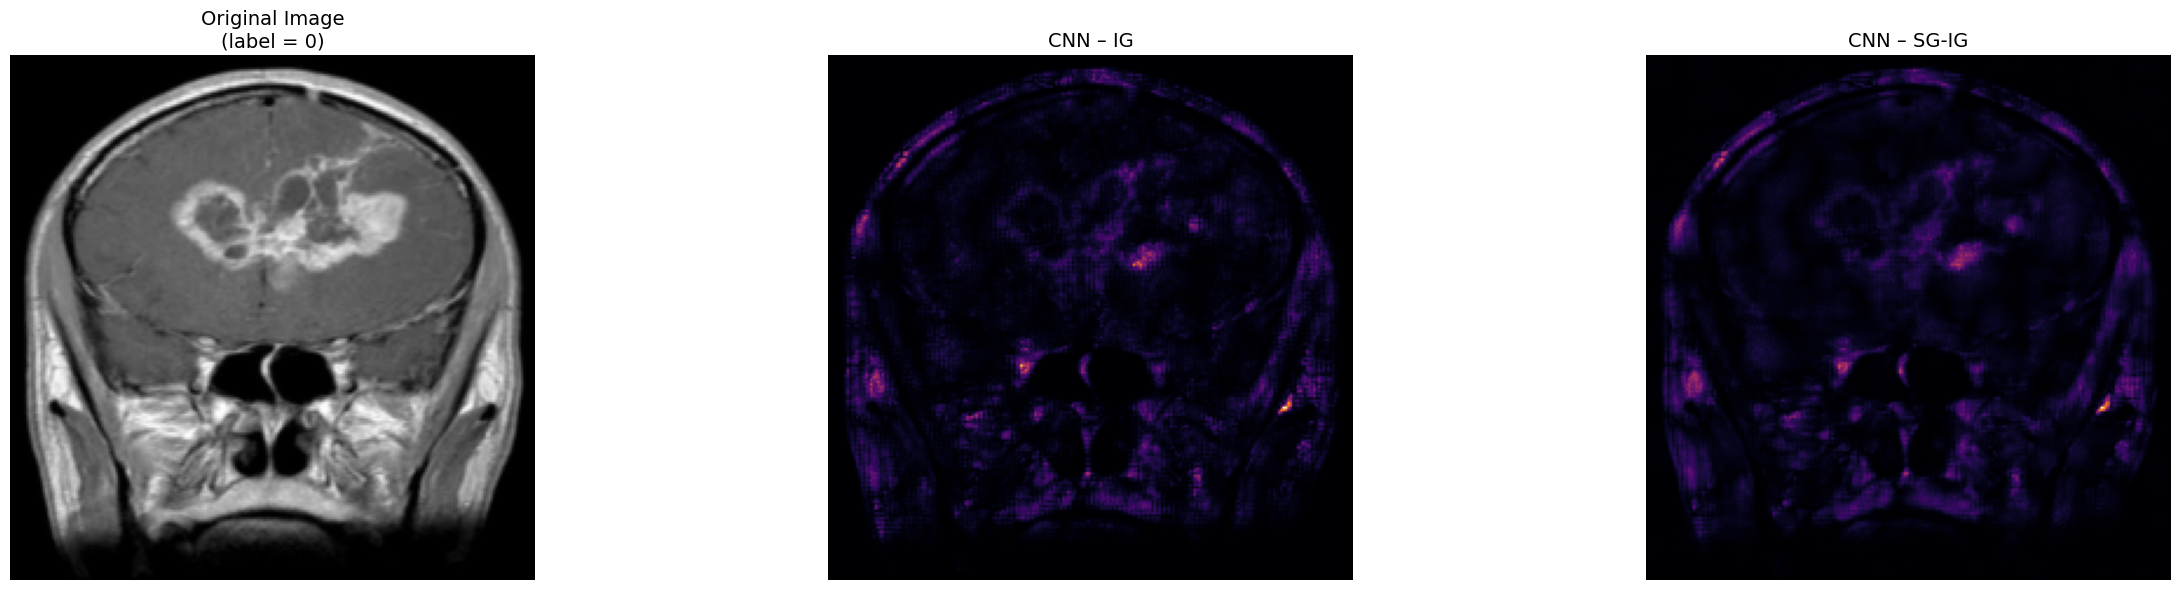

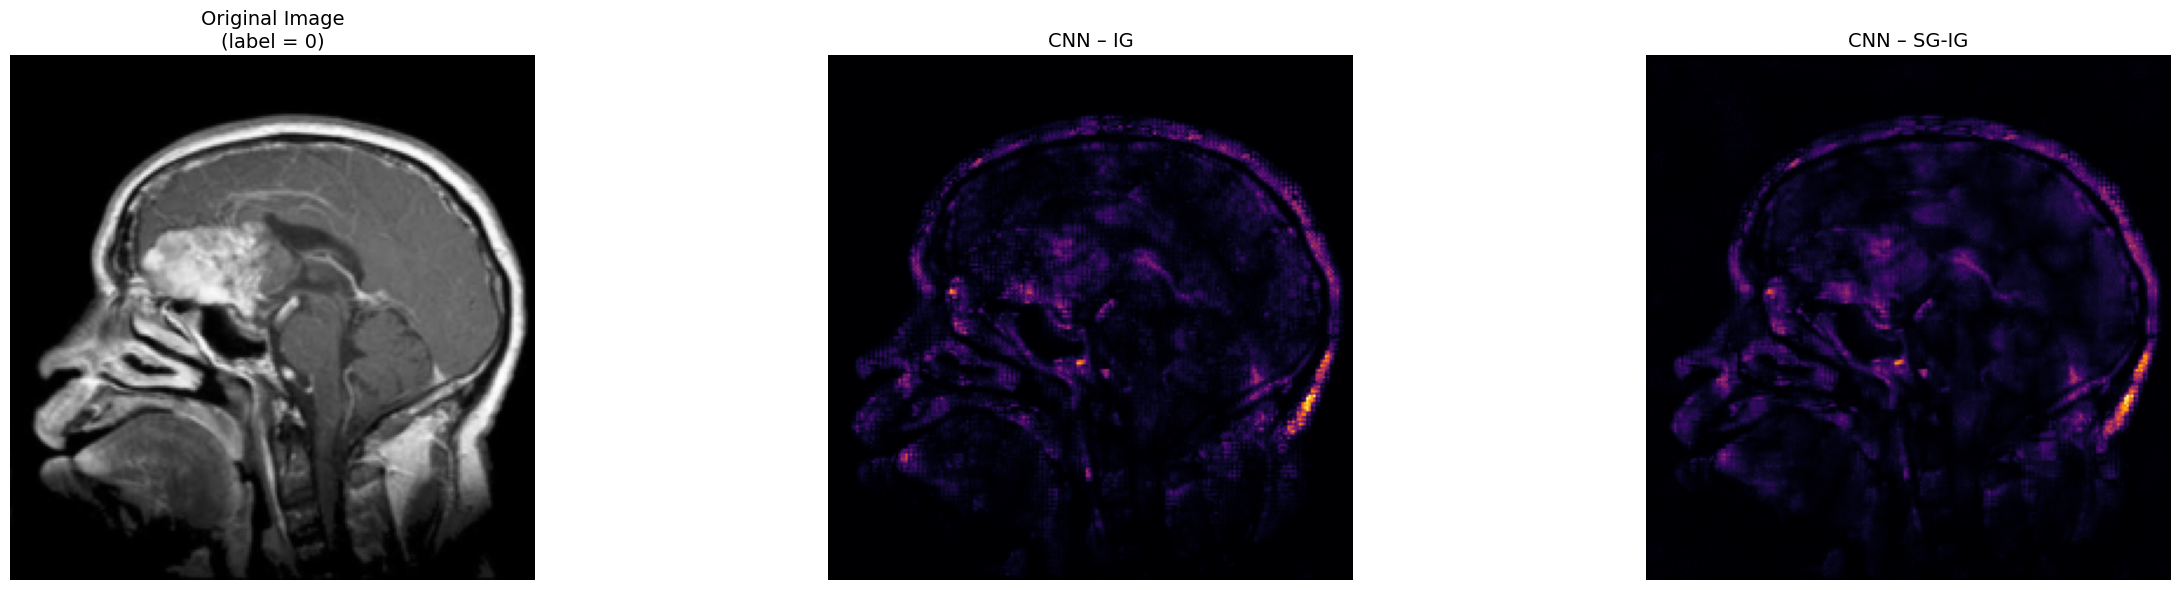

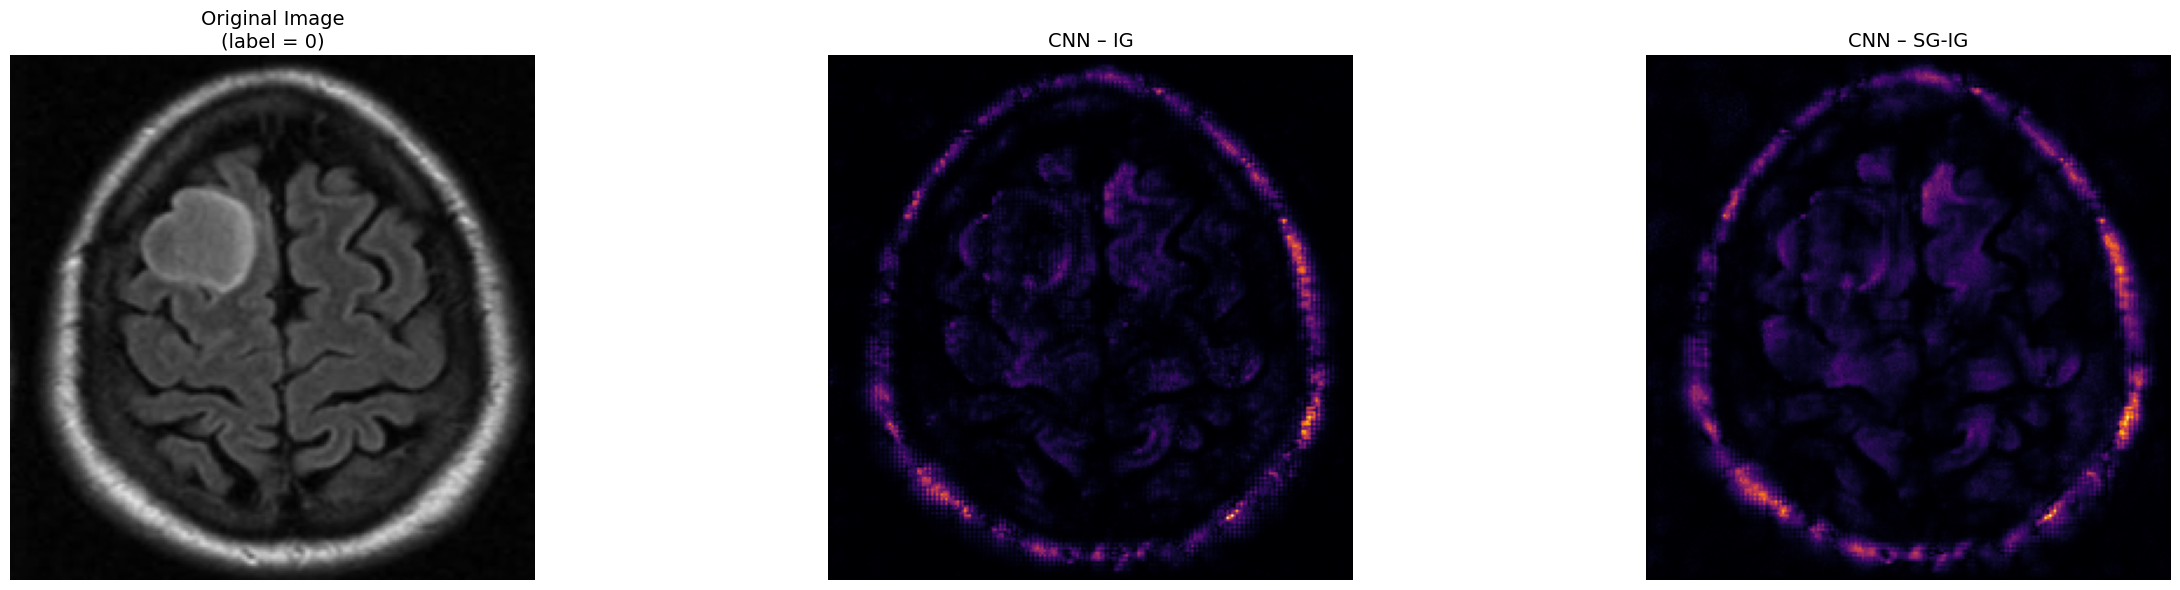

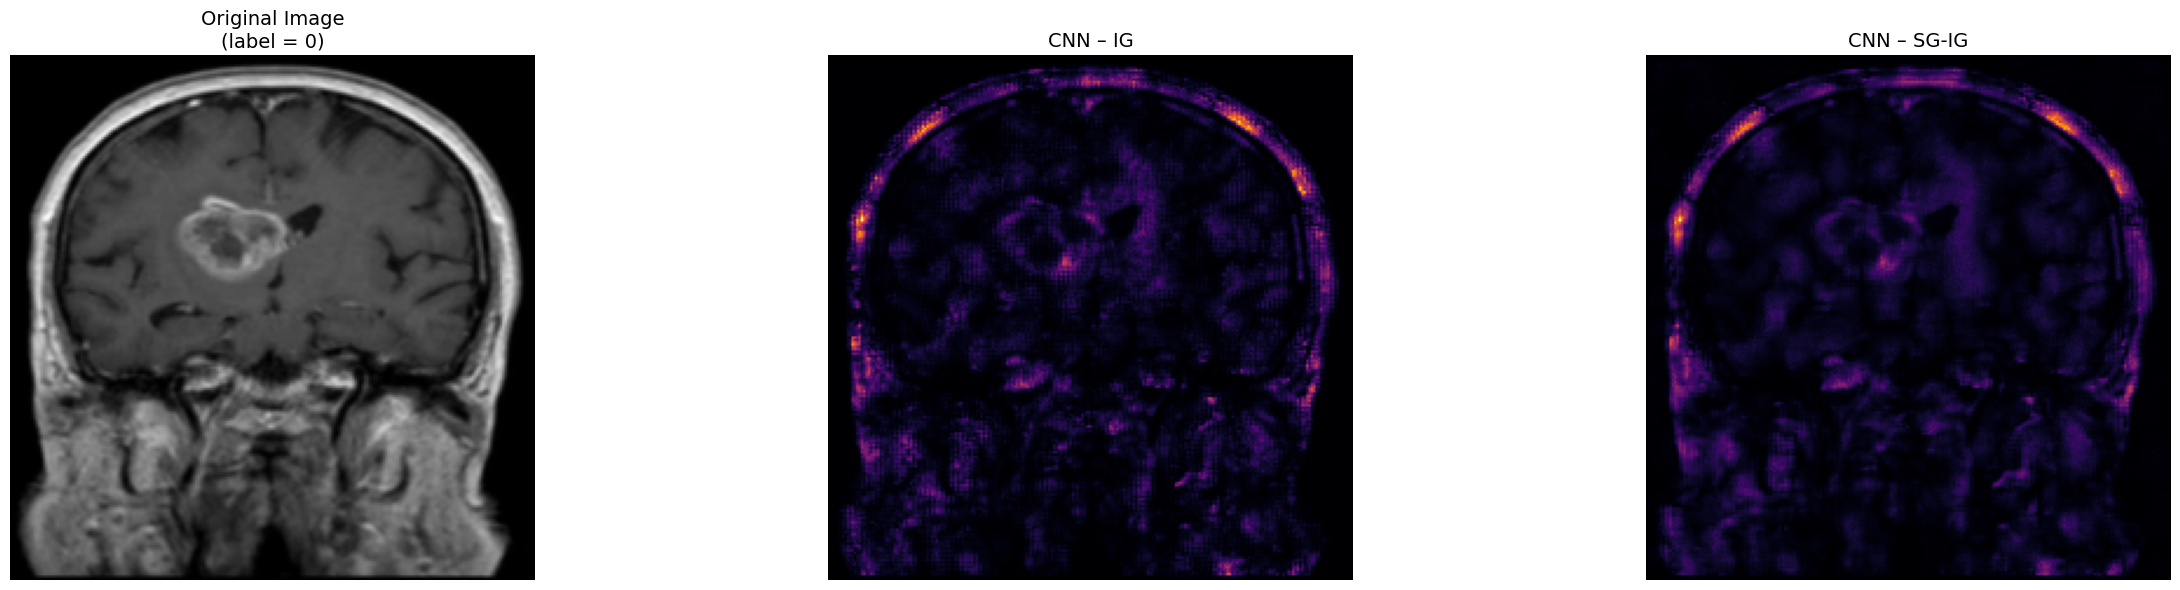

In [ ]:
explainer_images, explainer_labels = next(iter(test_loader))

batch_size = explainer_images.shape[0]

# batch size is 32 so I am going to do the first 4
for i in range(batch_size//8):

    explainer_image = explainer_images[i]
    explainer_label = explainer_labels[i].item()

    explainer_image_device = explainer_image.unsqueeze(0).to(device)

    def denormalize(x, mean, std):
        mean = torch.tensor(mean).view(1, 3, 1, 1).to(x.device)
        std = torch.tensor(std).view(1, 3, 1, 1).to(x.device)
        return x * std + mean


    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    explainer_image_denorm = denormalize(explainer_image_device, mean, std)
    baseline = torch.zeros_like(explainer_image_denorm)

    # CNN
    cnn_ig = integrated_gradients(
        model=model,
        x=explainer_image_denorm,
        baseline=baseline,
        m_steps=50
    )

    cnn_sg_ig = smooth_integrated_gradients(
        model=model,
        x=explainer_image_denorm,
        baseline=baseline,
        m_steps=50,
        n_samples=20,
        noise_sigma=0.1
    )



    def to_heatmap(attr):
        # attr: shape (1, 3, H, W)
        attr = attr.squeeze(0).detach().cpu().numpy()   # (3, H, W)
        return np.abs(attr).mean(axis=0)                # (H, W)

    def to_numpy_image(t):
        """Convert (1,3,H,W) or (3,H,W) tensor to (H,W,3) NumPy for plotting."""
        t = t.detach().cpu()
        if t.ndim == 4:  # (1,C,H,W)
            t = t.squeeze(0)
        t = t.permute(1, 2, 0)   # C,H,W → H,W,C
        return t.numpy()

    # ORIGINAL IMAGE (DENORMALIZED)

    orig_np = to_numpy_image(explainer_image_denorm)
    orig_np = np.clip(orig_np, 0, 1)   # ensure valid RGB range


    # HEATMAPS

    heatmaps = [
        ("CNN – IG", to_heatmap(cnn_ig)),
        ("CNN – SG-IG", to_heatmap(cnn_sg_ig)),
    ]

    # PLOT ALL TOGETHER
    fig, axes = plt.subplots(1, 1 + len(heatmaps), figsize=(26, 6))

    # Original Image
    axes[0].imshow(orig_np)
    axes[0].set_title(f"Original Image\n(label = {explainer_label})", fontsize=14)
    axes[0].axis("off")

    # Heatmaps
    for ax, (title, hm) in zip(axes[1:], heatmaps):
        ax.imshow(hm, cmap="inferno")
        ax.set_title(title, fontsize=14)
        ax.axis("off")

    plt.tight_layout()
    plt.show()